<h1><center>Stock News Webscrape </h1>

<h3><center>Goal Of Notebook: </h3>

<p><center> To be able to webscrape a stock's news from a set of particular website homepages </p>

In [1]:
'''
Importing the neccesary libraries
'''
import pandas as pd
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re 
from datetime import datetime
import urllib
import urllib.request
import requests

## Our Websites

<p> Websites we will use. </p>

In [2]:
websites = ['https://finance.yahoo.com',
 'https://www.marketwatch.com',  'https://edition.cnn.com/business'] 

## Adjusting previously stated funcitons

<p> Remember before, our functions suited yahoo finance, but unfortuanetly every site doesn't use a standard html basis, so therefore we will have to adjust our functions to grab the information we want. </p>

<p> Unfortuanetly, CNN was a pain to parse to get the website's articles. There href links are widly incosistent, some don't contain the full path's for articles, while others do. There seems to be relaxed rules in place. So I had to get a bit creative in the logic. Basically, we need to make sure 'html' is in the link. This also happens to pull the sitemap, so we can rule that out with a 'not in' statement of logic. </p>

<p> Market watch pretty much follows the same rules as yahoo finance. We just need to attach the site url to the link, if the link does not contain the full path. </p>

<p> The function below works for all three of our websites. </p>

In [3]:
def getStockLinks(site, stock):
    '''
    Params:
    Website
    Stock
    ---------------------------------
    Function parses a url to find all of the a tags in the html
    From there it selects only the "a" tags where the stock is contained in the href link
    Only append links into our list of links if the link has not yet been appended
    
    Make sure 'html' is in the CNN's link and rule out the sitemap link
    Market watch follows the same rules as yahoo finance

    '''
    internal_links = [] 
    html = urlopen(site) #Grab the html
    bsObj = BeautifulSoup(html) #Turn html to bsObj
    for link in bsObj.findAll("a", href=re.compile('.*'+stock+'.*')): #Find a tags who href attribute have our stock in it
        link = link.attrs['href']
        
        if 'cnn' in site and 'html' in link: #CNN formatting - Need html in link its an indicator of a article
            link = 'http://cnn.com'+link #Append the begining of url to link
            if link not in internal_links and 'sitemap' not in link: #Don't care for CNN's sitemap
                internal_links.append(link)
        
        elif 'cnn' not in site:
            if link.startswith(site) and link not in internal_links: #More link formatting
                internal_links.append(link)
            elif link.startswith('https') == False:
                link = site+link
                if link not in internal_links:
                    internal_links.append(link)
    return internal_links


## Yahoo Finance Get Dates Fucntion

<p> Below we will create a function applicable to grabbing the publish times of a yahoo finance article. </p>

In [4]:
tesla_example_link = getStockLinks('https://finance.yahoo.com', 'tesla')
tesla_example_link

['https://finance.yahoo.com/news/teslas-musk-nears-750-million-090353446.html',
 'https://finance.yahoo.com/video/tesla-plans-reopen-california-factory-171357215.html',
 'https://finance.yahoo.com/news/tesla-drops-plan-recall-workers-175814495.html',
 'https://finance.yahoo.com/m/f9cc9a02-87b4-3116-ac0b-1cf002e1f6c7/tesla-boeing-moderna-lead.html',
 'https://finance.yahoo.com/news/ford-tesla-preparing-restart-u-134300108.html',
 'https://finance.yahoo.com/news/tesla-drops-plan-recall-workers-175814062.html']

In [5]:
def get_YAHOO_dates(links):
    '''
    Paramters:
    List of links
    -----------------------
    Takes a list of links and grabs the datetime of publishment
    for each link
    
    Designed to work with the YahooFinance HTML
    '''
    links_dict = {}
    for link in links:
        urlopen = requests.get(link).text 
        bsObj = BeautifulSoup(urlopen, 'html.parser') #Convert the html to a bsObj
            
        date = bsObj.find('time') #time tag is used for the published time
        if date is not None:
            str_date = date.get_text() #Get the text associated with the time tag
            date = datetime.strptime(str_date, '%B %d, %Y')
            links_dict[link] = date
    return links_dict

<p> And look at that we were able to create a mapping of a link to a datetime object. </p>

In [6]:
get_YAHOO_dates(tesla_example_link)

{'https://finance.yahoo.com/news/teslas-musk-nears-750-million-090353446.html': datetime.datetime(2020, 4, 28, 0, 0),
 'https://finance.yahoo.com/video/tesla-plans-reopen-california-factory-171357215.html': datetime.datetime(2020, 4, 27, 0, 0),
 'https://finance.yahoo.com/news/tesla-drops-plan-recall-workers-175814495.html': datetime.datetime(2020, 4, 27, 0, 0),
 'https://finance.yahoo.com/m/f9cc9a02-87b4-3116-ac0b-1cf002e1f6c7/tesla-boeing-moderna-lead.html': datetime.datetime(2020, 4, 28, 0, 0),
 'https://finance.yahoo.com/news/ford-tesla-preparing-restart-u-134300108.html': datetime.datetime(2020, 4, 27, 0, 0),
 'https://finance.yahoo.com/news/tesla-drops-plan-recall-workers-175814062.html': datetime.datetime(2020, 4, 27, 0, 0)}

## Market Watch Get Dates Function

<p> Below we will create a function applicable to grabbing the publish times of a market watch article. </p>

In [7]:
netflix_example_link = getStockLinks('https://www.marketwatch.com', 'netflix')
netflix_example_link

['https://www.marketwatch.com/story/heres-everything-coming-to-netflix-in-may-2020-and-whats-leaving-2020-04-22?mod=home-page']

In [8]:
def get_MW_dates(links):
    '''
    Paramters:
    List of links
    -----------------------
    Takes a list of links and grabs the datetime of publishment
    for each link
    
    Designed to work with the MarketWatch HTML
    '''
    def ampm(string):
        '''
        Parameters:
        datetime string
        ----------------------
        Converts a.m to AM or p.m to PM
        '''
        locate = re.compile(r'[ap]\.m\.') #pattern to match a.m or p.m
        ampm_pattern = re.findall(locate, string) #use re.findall to find the pattern
        ampm_match_string = ''.join(ampm_pattern)
        ampm = str.replace(ampm_match_string, '.', '').upper()
        ampm_string = str.replace(string, ampm_match_string, ampm)
        return ampm_string
    
    links_dict = {}
    for link in links:
        urlopen = requests.get(link).text
        bsObj = BeautifulSoup(urlopen, 'html.parser')
        
        date = bsObj.find('time') #where the date is located in the html

        
        str_date = date.get_text() #Convert date html into a string
        date_pattern = re.compile(r'[A-Za-z]{5}\.?\s[0-9]{1,2}\,\s[0-9]{4}') #pattern to match date
        time_pattern = re.compile(r'[0-9]{1,2}\:[0-9]{2}\s[a-z]{1}\.[a-z]{1}\.') #pattern to match time
            
        date_match = re.findall(date_pattern, str_date) #retrieve the date match
        time_match = re.findall(time_pattern, str_date) #retrieve the time match
            
        date_match_string = ''.join(date_match) #convert list of one date to a string
        time_match_string = ''.join(time_match) #convert list of one time to a string
            
        if len(date_match_string) != 0 or len(time_match_string) != 0:
            date_and_time = date_match_string + ' ' + time_match_string #Combine the date and time strings we have retrieved
            str_date = ampm(date_and_time) #convert a.m to AM so python strptime can work with it
            date = datetime.strptime(str_date, '%B %d, %Y %I:%M %p') #creates a datetime object that follows that pattern
            links_dict[link] = date #build the links_dict
    return links_dict
    

<p> Perfect, we were able to create a mapping of a link to a datetime object. </p>

In [9]:
get_MW_dates(netflix_example_link)

{'https://www.marketwatch.com/story/heres-everything-coming-to-netflix-in-may-2020-and-whats-leaving-2020-04-22?mod=home-page': datetime.datetime(2020, 4, 27, 6, 28)}

## CNN Get Dates Function

<p> Below we will create a function applicable to grabbing the publish times of a CNN article. </p>

In [10]:
facebook_example_link = getStockLinks('https://edition.cnn.com/business', 'facebook')
facebook_example_link

['http://cnn.com/2020/04/22/tech/facebook-india-reliance-jio/index.html',
 'http://cnn.com/2020/04/24/tech/facebook-video-calling-upgrades/index.html']

In [11]:
def get_CNN_dates(links):
    '''
    Paramters:
    List of links
    -----------------------
    Takes a list of links and grabs the datetime of publishment
    for each link
    
    Designed to work with the CNN HTML
    '''
    links_dict = {}
    for link in links:
        urlopen = requests.get(link).text
        bsObj = BeautifulSoup(urlopen, 'html.parser')
        
        date = bsObj.find("p", {'class':"update-time"}) #Where the date is located in the html

            
        str_date = date.get_text()
        date_pattern = re.compile('[A-Za-z]+\s[0-9]{1,2}\,\s[0-9]{4}') #pattern to match date
        time_pattern = re.compile(r'[0-9]{1,2}\:[0-9]{2}\s[A-Z]{2}') #pattern to match time
        
        date_match = re.findall(date_pattern, str_date) #retrieve the date match
        time_match = re.findall(time_pattern, str_date) #retrieve the time match
        
        date_match_string = ''.join(date_match) #convert list of one date to a string    
        time_match_string = ''.join(time_match) #convert list of one time to a string
        
        if len(date_match_string) != 0 or len(time_match_string) != 0:
            date_and_time = date_match_string + ' ' + time_match_string #combine the date and time strings we have retrieved
            date = datetime.strptime(date_and_time, '%B %d, %Y %I:%M %p') #creates a datetime object that follows that pattern
            links_dict[link] = date #build the links_dict
    
    return links_dict

<p> And once again we were able to create a mapping of a link to a datetime object. </p>

In [12]:
get_CNN_dates(facebook_example_link)

{'http://cnn.com/2020/04/22/tech/facebook-india-reliance-jio/index.html': datetime.datetime(2020, 4, 24, 1, 23),
 'http://cnn.com/2020/04/24/tech/facebook-video-calling-upgrades/index.html': datetime.datetime(2020, 4, 27, 8, 43)}

## Creating our StockInfo Class for Multiple Websites

<p> Unfortuanetly, the class methods are currently very limited because we are restrained to follow the CNN, yahoo finance, and market watch HTML formats. I decided that when calling the StockInfo object, only the stock wished to be queried is a neccesary parameter. I'd put URL as one of the parameters, but we can't go outside the realm of the three websites we have been using because we don't know the html formats of other websites. </p>

In [13]:
class StockInfo:
    def __init__(self, stock):
        '''
        Params: URL - Site where to grab data
        Stock - Keyword to query by
        '''
        self.stock = stock
        
    
    def getStockLinks(self, url):
        '''
        Params:
        Website
        Stock
        ---------------------------------
        Function parses a url to find all of the a tags in the html
        From there it selects only the "a" tags where the stock is contained in the href link
        Only append links into our list of links if the link has not yet been appended
        
        Make sure 'html' is in the CNN's link and rule out the sitemap link

        Market watch follows the same rules as yahoo finance
        '''
        stock = self.stock
        self.internal_links = [] 
        html = urlopen(url) #Grab the html
        bsObj = BeautifulSoup(html) #Turn html to bsObj
        for link in bsObj.findAll("a", href=re.compile('.*'+stock+'.*')): #Find a tags who href attribute have our stock in it
            link = link.attrs['href']
            
            if 'cnn' in url and 'html' in link: #CNN formatting - Need html in link its an indicator of a article
                link = 'http://cnn.com'+link #Append the begining of url to link
                if link not in self.internal_links and 'sitemap' not in link: #Don't care for CNN's sitemap
                    self.internal_links.append(link)
            
            elif 'cnn' not in url:
                if link.startswith(url) and link not in self.internal_links: #More link formatting
                    self.internal_links.append(link)
                elif link.startswith('https') == False:
                    link = url+link
                    if link not in self.internal_links:
                        self.internal_links.append(link)
        return self.internal_links
    
    
    def get_YAHOO_dates(self):
        '''
        Paramters:
        List of links
        -----------------------
        Takes a list of links and grabs the datetime of publishment
        for each link

        Designed to work with the YahooFinance HTML
        '''
        links = self.getStockLinks('https://finance.yahoo.com')
        self.YAHOO_links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text 
                bsObj = BeautifulSoup(urlopen, 'html.parser') #Convert the html to a bsObj

                date = bsObj.find('time') #time tag is used for the published time
                if date is not None:
                    str_date = date.get_text() #Get the text associated with the time tag
                    try:
                        date = datetime.strptime(str_date, '%B %d, %Y')
                    except:
                        date = datetime.strptime('January 01, 2000' '%B %d, %Y')
                    self.YAHOO_links_dict[link] = date
        except:
            pass
        return self.YAHOO_links_dict
    
    
    def get_MW_dates(self):
        '''
        Paramters:
        List of links
        -----------------------
        Takes a list of links and grabs the datetime of publishment
        for each link

        Designed to work with the MarketWatch HTML
        '''
        def ampm(string):
            '''
            Parameters:
            datetime string
            ----------------------
            Converts a.m to AM or p.m to PM
            '''
            locate = re.compile(r'[ap]\.m\.') #pattern to match a.m or p.m
            ampm_pattern = re.findall(locate, string) #use re.findall to find the pattern
            ampm_match_string = ''.join(ampm_pattern)
            ampm = str.replace(ampm_match_string, '.', '').upper()
            ampm_string = str.replace(string, ampm_match_string, ampm)
            return ampm_string

        links = self.getStockLinks('https://www.marketwatch.com')
        self.MW_links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text
                bsObj = BeautifulSoup(urlopen, 'html.parser')

                date = bsObj.find('time') #where the date is located in the html


                str_date = date.get_text() #Convert date html into a string
                date_pattern = re.compile(r'[A-Za-z]{5}\.?\s[0-9]{1,2}\,\s[0-9]{4}') #pattern to match date
                time_pattern = re.compile(r'[0-9]{1,2}\:[0-9]{2}\s[a-z]{1}\.[a-z]{1}\.') #pattern to match time

                date_match = re.findall(date_pattern, str_date) #retrieve the date match
                time_match = re.findall(time_pattern, str_date) #retrieve the time match

                date_match_string = ''.join(date_match) #convert list of one date to a string
                time_match_string = ''.join(time_match) #convert list of one time to a string

                if len(date_match_string) != 0 or len(time_match_string) != 0:
                    date_and_time = date_match_string + ' ' + time_match_string #Combine the date and time strings we have retrieved
                    str_date = ampm(date_and_time) #convert a.m to AM so python strptime can work with it
                    try:
                        date = datetime.strptime(str_date, '%B %d, %Y %I:%M %p') #creates a datetime object that follows that pattern
                    except:
                        date = datetime.strptime('January 01, 2000 12:00 AM', '%B %d, %Y %I:%M %p')                
                    self.MW_links_dict[link] = date #build the links_dict
        except:
            pass
        return self.MW_links_dict
    
    
    
    def get_CNN_dates(self):
        '''
        Paramters:
        List of links
        -----------------------
        Takes a list of links and grabs the datetime of publishment
        for each link

        Designed to work with the CNN HTML
        '''
        links = self.getStockLinks('https://edition.cnn.com/business')
        self.CNN_links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text
                bsObj = BeautifulSoup(urlopen, 'html.parser')

                date = bsObj.find("p", {'class':"update-time"}) #Where the date is located in the html


                str_date = date.get_text()
                date_pattern = re.compile('[A-Za-z]+\s[0-9]{1,2}\,\s[0-9]{4}') #pattern to match date
                time_pattern = re.compile(r'[0-9]{1,2}\:[0-9]{2}\s[A-Z]{2}') #pattern to match time

                date_match = re.findall(date_pattern, str_date) #retrieve the date match
                time_match = re.findall(time_pattern, str_date) #retrieve the time match

                date_match_string = ''.join(date_match) #convert list of one date to a string    
                time_match_string = ''.join(time_match) #convert list of one time to a string

                if len(date_match_string) != 0 or len(time_match_string) != 0:
                    date_and_time = date_match_string + ' ' + time_match_string #combine the date and time strings we have retrieved
                    try:
                        date = datetime.strptime(date_and_time, '%B %d, %Y %I:%M %p') #creates a datetime object that follows that pattern
                    except:
                        date = datetime.strptime('January 01, 2000 12:00 AM', '%B %d, %Y %I:%M %p')                
                    self.CNN_links_dict[link] = date #build the links_dict
        except:
            pass
        return self.CNN_links_dict


    

    def links_dataframe(self, links_dictionary, url):
        '''
        Params:
        Links Dictionary
        Website URL
        ------------------------------------
        Create a links dataframe with columns labeled as URL and Published Time

        Because the published time is a datetime datatype it is easy to sort with
        Then create a standard datetime format for all links
        '''
        links_dict = links_dictionary #DO NOT USE SELF - not neccesary 
        
        if len(links_dict) != 0: #Formatting if the dictionary is filled with data
            links_df = pd.DataFrame(list(links_dict.items()), columns=['URL', 'Published Time']) #Our two columns
            links_df.columns.name = url
            links_df.sort_values(by =['Published Time'], ascending=False, inplace=True) #Format the dates in descending order
            links_df['Published Time'] = links_df['Published Time'].dt.strftime('%b %d, %Y %I:%M %p') #Datetime format that all three websites will use
            return links_df
        else: #Otherwise return a empty dataframe
            links_df = pd.DataFrame(list(self.links_dict.items()), columns=['URL', 'Published Time'])
            return links_df
    

## Testing our Class

In [14]:
websites = ['https://finance.yahoo.com',
 'https://www.marketwatch.com',  'https://edition.cnn.com/business'] 

In [15]:
amazon = StockInfo('amazon')

In [16]:
amazon.stock

'amazon'

## Testing our get_dates Methods

In [17]:
yahoo_amazon = amazon.get_YAHOO_dates()
yahoo_amazon

{'https://finance.yahoo.com/m/7aca8e80-fbef-3ec1-95ae-49c210f189cc/amazon-can%E2%80%99t-avoid-a.html': datetime.datetime(2020, 4, 27, 0, 0)}

In [18]:
cnn_amazon = amazon.get_CNN_dates()
cnn_amazon

{'http://cnn.com/2020/04/22/tech/amazon-warehouse-bashir-mohamed/index.html': datetime.datetime(2020, 4, 22, 15, 26)}

In [19]:
mw_amazon = amazon.get_MW_dates()
mw_amazon

{'https://www.marketwatch.com/story/amazons-175000-worker-hiring-spree-suggests-strong-first-quarter-sales-despite-covid-19-analysts-say-2020-04-27?mod=home-page': datetime.datetime(2020, 4, 28, 7, 45)}

## Testing our dataframe builder method

In [20]:
amazon.links_dataframe(yahoo_amazon, 'https://finance.yahoo.com')

https://finance.yahoo.com,URL,Published Time
0,https://finance.yahoo.com/m/7aca8e80-fbef-3ec1...,"Apr 27, 2020 12:00 AM"


In [21]:
amazon.links_dataframe(cnn_amazon, 'https://edition.cnn.com/business')

https://edition.cnn.com/business,URL,Published Time
0,http://cnn.com/2020/04/22/tech/amazon-warehous...,"Apr 22, 2020 03:26 PM"


In [22]:
amazon.links_dataframe(mw_amazon, 'https://www.marketwatch.com')

https://www.marketwatch.com,URL,Published Time
0,https://www.marketwatch.com/story/amazons-1750...,"Apr 28, 2020 07:45 AM"


<p> Everything looks to be working so far... </p>

## Putting it all together

<p> The only task we have left is to add the send_mail method. </p>
<p> I also added some additional modifications like try and except statements to cover for unnacounted for changes in the websites html. </p>
<p> Future failures of the class will require investigation. </p>

In [23]:
class StockInfo:
    def __init__(self, stock):
        '''
        Params: URL - Site where to grab data
        Stock - Keyword to query by
        '''
        self.stock = stock
        


    def getStockLinks(self, url):
        '''
        Params:
        Website
        Stock
        ---------------------------------
        Function parses a url to find all of the a tags in the html
        From there it selects only the "a" tags where the stock is contained in the href link
        Only append links into our list of links if the link has not yet been appended
        
        Make sure 'html' is in the CNN's link and rule out the sitemap link

        Market watch follows the same rules as yahoo finance
        '''
        stock = self.stock
        self.internal_links = [] 
        html = urlopen(url) #Grab the html
        bsObj = BeautifulSoup(html) #Turn html to bsObj
        for link in bsObj.findAll("a", href=re.compile('.*'+stock+'.*')): #Find a tags who href attribute have our stock in it
            link = link.attrs['href']
            
            if 'cnn' in url and 'html' in link: #CNN formatting - Need html in link its an indicator of a article
                link = 'http://cnn.com'+link #Append the begining of url to link
                if link not in self.internal_links and 'sitemap' not in link: #Don't care for CNN's sitemap
                    self.internal_links.append(link)
            
            elif 'cnn' not in url:
                if link.startswith(url) and link not in self.internal_links: #More link formatting
                    self.internal_links.append(link)
                elif link.startswith('https') == False:
                    link = url+link
                    if link not in self.internal_links:
                        self.internal_links.append(link)
        return self.internal_links


    
    
    def get_YAHOO_dates(self):
        '''
        Paramters:
        List of links
        -----------------------
        Takes a list of links and grabs the datetime of publishment
        for each link

        Designed to work with the YahooFinance HTML
        '''
        links = self.getStockLinks('https://finance.yahoo.com')
        self.YAHOO_links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text 
                bsObj = BeautifulSoup(urlopen, 'html.parser') #Convert the html to a bsObj

                date = bsObj.find('time') #time tag is used for the published time
                if date is not None:
                    str_date = date.get_text() #Get the text associated with the time tag
                    try:
                        date = datetime.strptime(str_date, '%B %d, %Y')
                    except:
                        date = datetime.strptime('January 01, 2000' '%B %d, %Y')
                    self.YAHOO_links_dict[link] = date
        except:
            pass
        return self.YAHOO_links_dict
    
    
    def get_MW_dates(self):
        '''
        Paramters:
        List of links
        -----------------------
        Takes a list of links and grabs the datetime of publishment
        for each link

        Designed to work with the MarketWatch HTML
        '''
        def ampm(string):
            '''
            Parameters:
            datetime string
            ----------------------
            Converts a.m to AM or p.m to PM
            '''
            locate = re.compile(r'[ap]\.m\.') #pattern to match a.m or p.m
            ampm_pattern = re.findall(locate, string) #use re.findall to find the pattern
            ampm_match_string = ''.join(ampm_pattern)
            ampm = str.replace(ampm_match_string, '.', '').upper()
            ampm_string = str.replace(string, ampm_match_string, ampm)
            return ampm_string

        links = self.getStockLinks('https://www.marketwatch.com')
        self.MW_links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text
                bsObj = BeautifulSoup(urlopen, 'html.parser')

                date = bsObj.find('time') #where the date is located in the html

                if date is not None:
                    str_date = date.get_text() #Convert date html into a string
                    date_pattern = re.compile(r'[A-Za-z]{5}\.?\s[0-9]{1,2}\,\s[0-9]{4}') #pattern to match date
                    time_pattern = re.compile(r'[0-9]{1,2}\:[0-9]{2}\s[a-z]{1}\.[a-z]{1}\.') #pattern to match time

                    date_match = re.findall(date_pattern, str_date) #retrieve the date match
                    time_match = re.findall(time_pattern, str_date) #retrieve the time match

                    date_match_string = ''.join(date_match) #convert list of one date to a string
                    time_match_string = ''.join(time_match) #convert list of one time to a string

                    if len(date_match_string) != 0 or len(time_match_string) != 0:
                        date_and_time = date_match_string + ' ' + time_match_string #Combine the date and time strings we have retrieved
                        str_date = ampm(date_and_time) #convert a.m to AM so python strptime can work with it
                        try:
                            date = datetime.strptime(str_date, '%B %d, %Y %I:%M %p') #creates a datetime object that follows that pattern
                        except:
                            date = datetime.strptime('January 01, 2000 12:00 AM', '%B %d, %Y %I:%M %p')
                        self.MW_links_dict[link] = date #build the links_dict
        except:
            pass

        return self.MW_links_dict
    
    
    
    def get_CNN_dates(self):
        '''
        Paramters:
        List of links
        -----------------------
        Takes a list of links and grabs the datetime of publishment
        for each link

        Designed to work with the CNN HTML
        '''
        links = self.getStockLinks('https://edition.cnn.com/business')
        self.CNN_links_dict = {}
        try:
            for link in links:
                urlopen = requests.get(link).text
                bsObj = BeautifulSoup(urlopen, 'html.parser')

                date = bsObj.find("p", {'class':"update-time"}) or bsObj.find("p", {'id':"published-timestamp"}) or bsObj.find('time') #Where the date is located in the html

                if date is not None:
                    str_date = date.get_text()
                    date_pattern = re.compile('[A-Za-z]+\s[0-9]{1,2}\,\s[0-9]{4}') #pattern to match date
                    time_pattern = re.compile(r'[0-9]{1,2}\:[0-9]{2}\s[A-Z]{2}') #pattern to match time

                    date_match = re.findall(date_pattern, str_date) #retrieve the date match
                    time_match = re.findall(time_pattern, str_date) #retrieve the time match

                    date_match_string = ''.join(date_match) #convert list of one date to a string    

                    time_match_string = ''.join(time_match) #convert list of one time to a string

                    if len(date_match_string) != 0 or len(time_match_string) != 0:
                        date_and_time = date_match_string + ' ' + time_match_string #combine the date and time strings we have retrieved
                        try:
                            date = datetime.strptime(date_and_time, '%B %d, %Y %I:%M %p') #creates a datetime object that follows that pattern
                        except:
                            date = datetime.strptime('January 01, 2000 12:00 AM', '%B %d, %Y %I:%M %p')
                        self.CNN_links_dict[link] = date #build the links_dict
        except:
            pass

        return self.CNN_links_dict


    

    def links_dataframe(self, links_dictionary, url):
        '''
        Params:
        Links Dictionary
        Website URL
        ------------------------------------
        Create a links dataframe with columns labeled as URL and Published Time

        Because the published time is a datetime datatype it is easy to sort with
        Then create a standard datetime format for all links
        '''
        links_dict = links_dictionary #DO NOT USE SELF - not neccesary 
        
        if len(links_dict) != 0: #Formatting if the dictionary is filled with data
            links_df = pd.DataFrame(list(links_dict.items()), columns=['URL', 'Published Time']) #Our two columns
            links_df.columns.name = url
            links_df.sort_values(by =['Published Time'], ascending=False, inplace=True) #Format the dates in descending order
            links_df['Published Time'] = links_df['Published Time'].dt.strftime('%b %d, %Y %I:%M %p') #Datetime format that all three websites will use
            return links_df
        else: #Otherwise return a empty dataframe
            links_df = pd.DataFrame(list(links_dict.items()), columns=['URL', 'Published Time'])
            return links_df

    
    def send_mail(self, email, password):
        '''
        Parameters:
        An email username
        An email password
        The stockclass object
        ------------------------------------
        Create a personalized email with the bulk of the html
        being about the links dataframe
        '''
        
        yahoo = self.links_dataframe(self.get_YAHOO_dates(), 'https://finance.yahoo.com')
        cnn = self.links_dataframe(self.get_CNN_dates(), 'https://edition.cnn.com/business')
        mw = self.links_dataframe(self.get_MW_dates(), 'https://www.marketwatch.com')
        
        me = email #Email of sender
        you = email #Email of receiver - obviously we are sending an email to ourselves

        #Begin to build the message
        msg = MIMEMultipart('alternative')
        msg['Subject'] = "Link"
        msg['From'] = me
        msg['To'] = you

        #Begin formatting your html preferences
        html = html = """\
    <html>
      <head> </head>
      <body>
      <h1>Hi John Smith, <br> Below is the news for {0} Stock On {1}</h1>
      <h2>Let me know if you want information for a different stock</h2>
      """.format(self.stock.capitalize(), datetime.now().strftime('%B-%d-%Y') ) #Use format to have a flexible header

        html += '<h3>Here is {0} stock information<h3>'.format(self.stock.capitalize())
        yahoo_html  = yahoo.to_html() #Converts our table dataframe to html directly
        cnn_html = cnn.to_html()
        mw_html = mw.to_html()
        html += yahoo_html + '<br>'
        html += cnn_html + '<br>'
        html += mw_html + '<br>'


        html += """
        </body>
    </html>
    """
        part2 = MIMEText(html,'html') #part one was the subject, from, to

        #Below are the neccessary mail configurations
        msg.attach(part2)
        mail = smtplib.SMTP('smtp.gmail.com', 587)
        mail.ehlo()
        mail.starttls()
        mail.login(email, password)
        mail.sendmail(me, you, msg.as_string())
        mail.quit()


## Testing the send_mail Method

In [24]:
amazon = StockInfo('amazon')

In [25]:
amazon.send_mail('email', 'password')

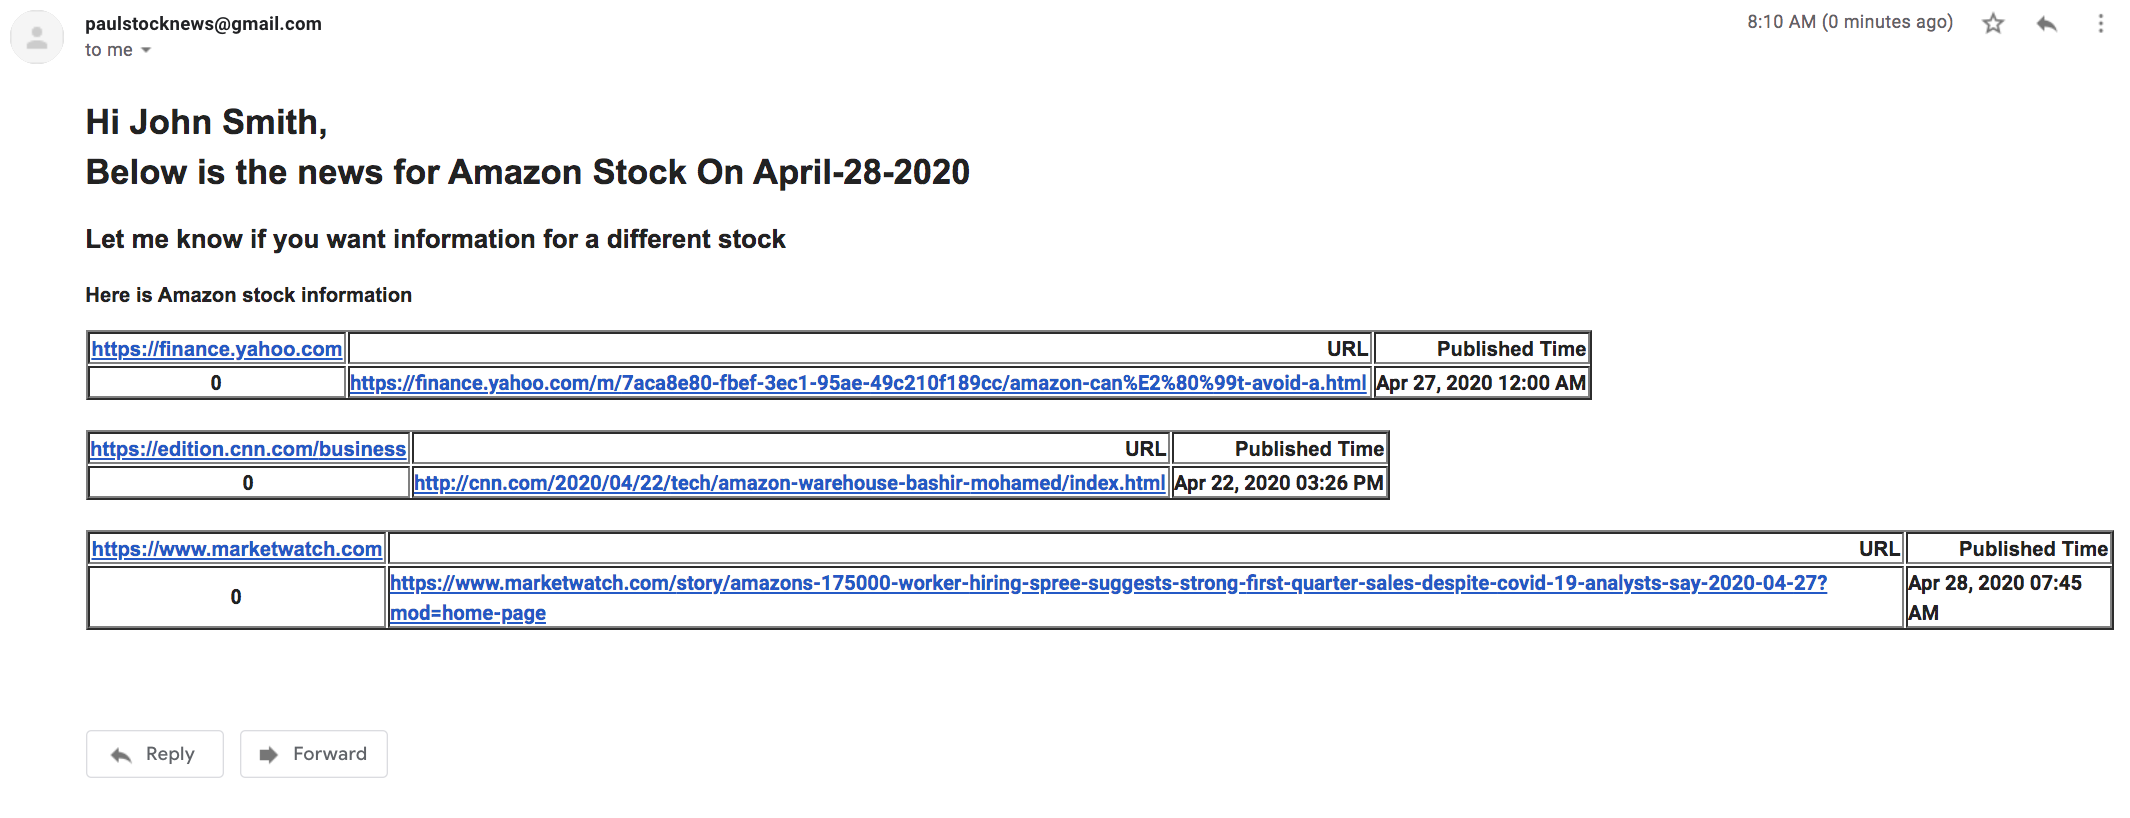

In [26]:
from IPython.display import Image
Image(filename="/Users/paulvicks/Documents/AmazonEmail.png")

<p> And just like that we have succesfully built a class that will send us an email with links that are about our stock. There is still a ways to go to optimize this process. Note this is a webscrape and not a web crawl. </p>

<h4> I will attach the link to the script version of this notebook below. </h4>

https://github.com/pvicks585/stock_news/blob/master/stockinfo_multiple_sites.py